Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.



In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

sns.set(
    font_scale=1.6
)

In [5]:
data = pd.read_csv('experiment_lesson_4.csv')

In [6]:
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


### Постройте графики распределения в разбивке по группам и районам

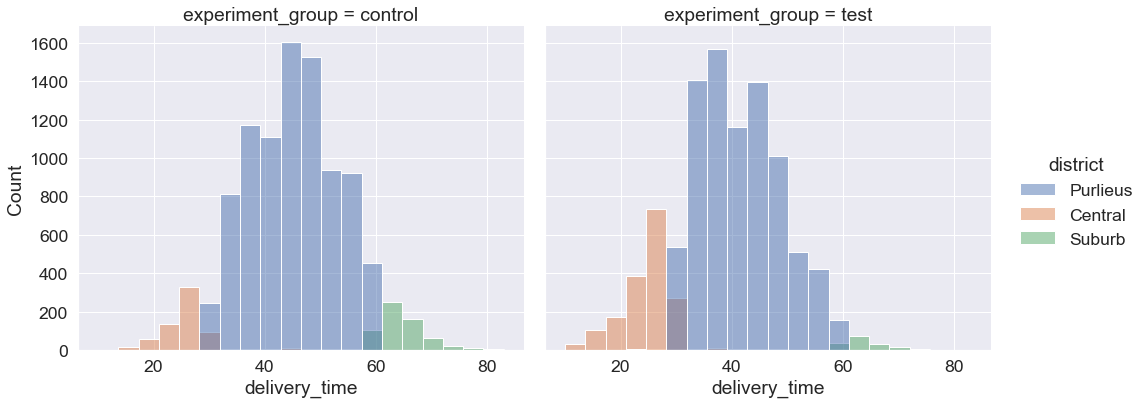

In [29]:
sns.displot(data=data, x='delivery_time', hue='district', col='experiment_group', height=6, aspect=1.2, bins=20)

In [28]:
??sns.displot

### Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [63]:
test = data \
    .groupby('experiment_group', as_index=False) \
    .agg({'delivery_time':'count'}) \
    .rename(columns={'delivery_time':'count_obs'}) \
    .query('experiment_group == "test"') \
    .reset_index(drop=True)
test

,experiment_group,count_obs
0,test,10104


In [64]:
control = data \
    .groupby('experiment_group', as_index=False) \
    .agg({'delivery_time':'count'}) \
    .rename(columns={'delivery_time':'count_obs'}) \
    .query('experiment_group == "control"') \
    .reset_index(drop=True)

In [67]:
delta = abs(test.count_obs - control.count_obs)
delta

0    12
Name: count_obs, dtype: int64

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Вообще для выборок таких колоссальных размеров мы не обязаны это делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно :)

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам.

In [69]:
st.normaltest(data[data.experiment_group == 'test'].delivery_time)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [71]:
st.normaltest(data[data.experiment_group == 'control'].delivery_time)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [75]:
sd_test = np.std(data[data.experiment_group == 'test'].delivery_time)
sd_test

9.882819260031312

In [78]:
sd_control = np.std(data[data.experiment_group == 'control'].delivery_time)
sd_control

9.989522000653128

### Проведем t-тест

In [79]:
sample_test = data[data.experiment_group == 'test'].delivery_time

In [80]:
sample_control = data[data.experiment_group == 'control'].delivery_time

In [82]:
st.ttest_ind(sample_test, sample_control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

### На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

In [88]:
 100 - sample_test.mean() / sample_control.mean() * 100

13.354653121660803